# Geometría visual del plano

Los conceptos esenciales que estudiaremos en este tema son:

- Las transformaciones que sufren las escenas planas cuando se observan en una imagen se representan con matrices (3x3) llamadas "homografías", que actúan sobre las coordenadas homogéneas de los puntos.


- Una homografía H se aplica a todos los puntos de una imagen de forma eficiente con la función `cv.warpPerspective`.


- Las homografías se deducen del efecto que produce la transformación en (al menos) 4 puntos. Para ello utilizamos `cv.findHomograpy`.

Esto permite rectificar planos (deshacer la perspectiva y recuperar las medidas reales) si detectamos un objeto conocido en la escena. También podemos crear diferentes efectos basados en la transformación de cuadriláteros.


<img src="../images/demos/rectifbig.png" width="50%">

## Grupos de transformaciones

Las transformaciones más importantes de la geometría visual se organizan en grupos progresivamente más generales:

<img src="../images/demos/transf2d.svg" width="600px"/>

Todas ellas pueden expresarse de forma lineal (multiplicando por una determinada matriz) usando coordenadas homogéneas. Las ilustramos en el plano (matrices $3\times3$), pero el concepto se aplica igualmente al espacio 3D con matrices $4\times4$).


Las transformaciones **euclídeas** (o rígidas) son las que solo incluyen desplazamientos y rotaciones. Las matrices de coeficientes tienen la siguiente estructura:


$$ D(d_x,d_y) \equiv
  \begin{bmatrix}1 & 0 & d_x\\
                 0 & 1 & d_y\\
                 0 & 0 & 1  \end{bmatrix}\quad
  \quad
  R(\alpha)\equiv\begin{bmatrix}\cos(\alpha) & -\sin(\alpha) & 0\\
                 \sin(\alpha) & \cos(\alpha) & 0\\
                 0 & 0 & 1  \end{bmatrix}$$
                 
Dentro de un momento veremos que consiguen el efecto deseado al operar sobre las coordenadas homogéneas de los puntos.


Las transformaciones **similares** incluyen también escalados uniformes:

$$
S(s)\equiv \begin{bmatrix}s & 0 & 0\\
                 0 & s & 0\\
                 0 & 0 & 1  \end{bmatrix}$$

Este tipo de transformación (a veces se llaman también *métrica*) preserva completamente la forma de los objetos. En realidad solo cambiamos el sistema de referencia.


Las transformaciones **afines** admiten también escalados no uniformes. 

$$
S(s_x,s_y)\equiv\begin{bmatrix}  s_x & 0 & 0\\
                 0 & s_y & 0\\
                 0 & 0 & 1  \end{bmatrix}$$

Al combinar este efecto con rotaciones se puede estirar o comprimir el objeto en cualquier dirección.

La composición de transformaciones equivale al producto de matrices: cuando se efectúa una secuencia de transformaciones, el resultado es equivalente a aplicar una única matriz que es el producto de todas ellas.

$$T_3 (T_2 (T_1 x)) = (T_3T_2T_1)x$$

El grupo afín tiene la estructura siguiente:

$$
\begin{bmatrix}  x & x & x\\
                 x & x & x\\
                 0 & 0 & x  \end{bmatrix}$$
                 
Esto quiere decir que cuando se combinan desplazamientos, rotaciones y escalados no uniformes la matriz resultante o equivalente tiene dos ceros en la tercera fila, y el resto de los elementos puede ser cualquiera. La tercera coordenada homogénea solo se utiliza para "implementar" los desplazamientos. Una transformación afín es una operación esencialmente lineal sobre las coordenadas cartesianas (multiplicar por constantes y sumar). Veremos que puede ser útil como aproximación, pero no sirve para modelar la perspectiva, que es esencialmente no lineal (involucra una división de coordenadas). 



En las transformaciones **proyectivas** aparecen los 9 elementos.

$$
\begin{bmatrix}  x & x & x\\
                 x & x & x\\
                 x & x & x  \end{bmatrix}$$
                 
Estas sí incluyen las transformaciones de perspectiva. (Cuando estudiemos el modelo de cámara en el capítulo siguiente  veremos que la clave para implementar la división de coordenadas es "no hacerlo": se deja para el final, cuando recuperamos las coordenadas cartesianas para dibujar. Mientras tanto podemos continuar operarando de forma lineal.)

### Invariantes

Cada grupo de transformaciones mantiene invariantes ciertas propiedades geométricas. En realidad, son estos invariantes los que realmente caracterizan a cada grupo.




Las transformaciones euclídeas matienen las **distancias** entre puntos. Las puertas, ventanas, el tejado de la casita del dibujo de arriba son del mismo tamaño.

Las transformaciones similares mantienen los **ángulos** (y los ratios de distancias). Los ángulos rectos, los ángulos del tejado, etc. son iguales.

Las transformaciones afines mantienen el **paralelismo** (y proporciones de áreas, y proporciones de distancias en la misma dirección). Los lados opuestos de la casa, puertas y ventanas, se mantienen paralelos, aunque los ángulos se deforman. Pero el área de la puerta dividida por la del tejado se mantiene constante. Se conserva bastante estructura.

Las transformaciones proyectivas mantienen las **líneas rectas**. Se pierde el paralelismo, los ángulos, las distancias, proporciones de áreas y de distancias... Pero sigue quedando suficiente estructura para poder reconstruir la realidad.
Por ejemplo, se preserva el **cross-ratio** de cuatro puntos en una recta, que se define como muestra la figura:

<img src="../images/demos/cross-ratio.png"/>

$$\rho= \frac{a}{a+b} \; \frac{c}{c+b}$$

Las transformaciones de *perspectiva* que observamos en las imágenes de un plano tomadas con una cámara son un caso especial de las proyectivas.

Si vemos cuatro puntos alineados el valor de cross-ratio $\rho$ será el mismo en el mundo real y en cualquier imagen. Da igual la posición de la cámara y el zoom elegido.

En principio este invariante se puede utilizar para reconocer objetos, pero es numéricamente muy impreciso. En la actualidad se recomiendan otros métodos.

Nota: Todos los resultados de este tema y los siguientes suponen que la cámara no tiene distorsión radial. Puedes comprobarlo fácilmente viendo si las líneas rectas se curvan cerca de los bordes de la imagen. Las cámaras modernas tienen ópticas bastante buenas, por lo que la distorsión radial es inapreciable a menos que se trabaje con campos de visión muy amplios.



**Experimento**: Comprueba en dos imágenes de una escena en la que puedas identificar 4 puntos alineados que su cross-ratio es aproximadamente igual.

La siguiente imagen muestra el típico efecto de perspectiva.

![poles](../images/poles2.jpg)

Suponiendo que los postes telefónicos están situados a la misma distancia ($a=b=c$), el cross ratio de cada 4 de ellos será $\rho=1/4$. 

Entonces, si marcamos la base de 3 de ellos consecutivos, podemos deducir la posición del siguiente. Y así sucesivamente, podemos predecir la posición de todos los que queramos de la secuencia. En el ejemplo siguiente se han marcado con el ratón los tres primeros puntos, etiquetados con 0, 1, 2. Los tres puntos siguientes se han deducido mediante este procedimiento. 

![poles](../images/demos/cr2.png)

Además, podemos deducir directamente el punto de fuga (el cuarto punto rojo), con el cross-ratio de 3 puntos equiespaciados y el cuarto en el infinito ($a=b,\; c\rightarrow\infty$).

Lo mismo con la parte superior de los postes:

![poles](../images/demos/cr1.png)

Ojo: la posición estimada es muy sensible al punto donde marcamos con el ratón.

**Ejercicio CR**: reproduce este experimento.

### Herramientas

In [1]:
import numpy as np
import cv2   as cv

import matplotlib.pyplot as plt
import numpy.linalg      as la

from ipywidgets          import interactive

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    plt.imshow(x, "gray")

# para imprimir arrays con el número de decimales deseados
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

# imprime un array con pocos decimales
def sharr(a, prec=3):
    with printoptions(precision=prec, suppress=True):
        print(a)
    
# dibuja un polígono cuyos nodos son las filas de un array 2D
def shcont(c, color='blue', nodes=True):
    x = c[:,0]
    y = c[:,1]
    x = np.append(x,x[0])
    y = np.append(y,y[0])
    plt.plot(x,y,color)
    if nodes: plt.plot(x,y,'.',color=color, markerSize=11)

In [2]:
# crea un vector (array 1D)
# (no es imprescindible, numpy admite tuplas o listas en muchas funciones,
# pero a esta función es útil a veces para aplicar operaciones aritméticas)
def vec(*argn):
    return np.array(argn)

# convierte un conjunto de puntos ordinarios (almacenados como filas de la matriz de entrada)
# en coordenas homogéneas (añadimos una columna de 1)
def homog(x):
    ax = np.array(x)
    uc = np.ones(ax.shape[:-1]+(1,))
    return np.append(ax,uc,axis=-1)

# convierte en coordenadas tradicionales
def inhomog(x):
    ax = np.array(x)
    return ax[..., :-1] / ax[...,[-1]]

# estas dos funciones funcionan en espacios de cualquier dimensión.

La función de umucv `htrans` aplica una homografía H a un conjunto de puntos almacenados como filas de una matriz.

Internamente convierte a coordenadas homogéneas, se multiplican todos los puntos, y se convierte el resultado a coordenadas cartesianas. La costumbre de almacenar los puntos por filas hace que haya que multiplicar a la derecha por matriz traspuesta. Si estuvieran almacenados por columnas se multiplicaría directamente por la izquierda: $(Hx)^\mathsf T = x^\mathsf T H^\mathsf T$

In [3]:
# aplica una transformación homogénea h a un conjunto
# de puntos ordinarios, almacenados como filas
def htrans(h,x):
    return inhomog(homog(x) @ h.T)

Definimos las matrices homogéneas de desplazamientos, rotaciones y cambios de escala.

In [4]:
def desp(d):
    dx,dy = d
    return np.array([
            [1,0,dx],
            [0,1,dy],
            [0,0,1]])

def scale(s):
    sx,sy = s
    return np.array([
            [sx,0,0],
            [0,sy,0],
            [0,0,1]])

# rotación eje "vertical" del plano
def rot3(a):
    c = np.cos(a)
    s = np.sin(a)
    return np.array([
            [c,-s,0],
            [s, c,0],
            [0, 0,1]])

pi = np.pi
degree = pi/180

### Experimentos

Creamos una figura de referencia para ver el resultado de diferentes transformaciones.

In [5]:
ref = np.array(
   [[0,   0  ],
    [0,   1  ],
    [0.5, 1  ],
    [0.5, 0.5],
    [1,   0.5],
    [1,   0  ]])

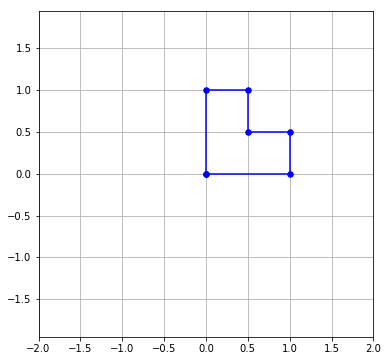

In [6]:
fig(6,6); 
shcont(ref); plt.axis('equal'); plt.axis([-2,2,-2,2]); plt.grid();

Podemos observar interactivamente el efecto de un desplazamiento:

In [7]:
# cada vez que movemos el trackbar
def fun(a = 0):
    # construimos la transformación con el nuevo parámetro
    H = desp((a,0))
    #print(H)
    
    # transformamos los puntos de la referencia
    img = htrans(H,ref)
    #print(img)
    
    fig(12,6)
    # dibujamos el objeto de partida
    plt.subplot(1,2,1)
    shcont(ref)
    plt.axis('equal'); plt.axis([-2,2,-2,2]); plt.grid()
    
    # dibujamos el objeto transformado
    plt.subplot(1,2,2)
    shcont(img,color='red')
    plt.axis('equal'); plt.axis([-2,2,-2,2]); plt.grid()

interactive(fun, a=(-1,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0, min=-1.0), Output()), _dom_classes=('wi…

Normalmente el plano transformado es distinto del inicial, aunque para comparar el efecto de algunas transformaciones podemos dibujarlas juntas:

In [8]:
def fun(a = 0.2):
    H = desp((a,0))
    img = htrans(H,ref)
    
    fig(6,6)
    shcont(ref)
    shcont(img,color='red')
    plt.axis('equal'); plt.axis([-2,2,-2,2]); plt.grid()

interactive(fun, a=(-1,1,0.1))

interactive(children=(FloatSlider(value=0.2, description='a', max=1.0, min=-1.0), Output()), _dom_classes=('wi…

Ahora comprobamos el efecto de un escalado.

In [9]:
def fun(a = 1.6):
    H = scale((a,a))
    #print(H)
    img = htrans(H,ref)
    
    fig(6,6)
    shcont(ref)
    shcont(img,color='red')
    plt.axis('equal'); plt.axis([-2,2,-2,2]); plt.grid()

interactive(fun, a=(0,2,0.2))

interactive(children=(FloatSlider(value=1.6, description='a', max=2.0, step=0.2), Output()), _dom_classes=('wi…

Observa que el "centro de expansión" es el origen (0,0). 
Si queremos escalar desde otro punto tenemos que trasladar la imagen, escalar y devolverla a su posición inicial. Esto es un buen ejemplo de la composición de transformaciones simples para conseguir un efecto más complejo. 

In [10]:
def fun(a = 1.6):
    H = desp((0.5,0.5)) @ scale((a,a)) @ desp(-vec(0.5,0.5))
    img = htrans(H,ref)
    
    fig(6,6)
    shcont(ref)
    shcont(img,color='red')
    plt.axis('equal'); plt.axis([-2,2,-2,2]); plt.grid()

interactive(fun, a=(0,2,0.2))

interactive(children=(FloatSlider(value=1.6, description='a', max=2.0, step=0.2), Output()), _dom_classes=('wi…

Las transformaciones **similares** combinan desplazamientos, rotaciones y escalados uniformes:

In [11]:
def fun(s = 1.6, a = 30):
    H = desp(-vec(1,1)/2) @ scale((s,s)) @ rot3(a*degree) @ desp(-vec(0.5,0.5))
    img = htrans(H,ref)
    
    fig(6,6)
    shcont(ref)
    shcont(img,color='red')
    plt.axis('equal'); plt.axis([-2,2,-2,2]); plt.grid()

interactive(fun, s=(0,2,0.1), a=(-180,180,10))

interactive(children=(FloatSlider(value=1.6, description='s', max=2.0), IntSlider(value=30, description='a', m…

Observa que estamos rotando la figura respecto a un punto que no es el origen. Lo conseguimos de nuevo con desplazamientos del objeto.

Si realizamos un escalado no uniforme obtenemos una **transformación afín**, que permite aproximar las vistas en *perspectiva débil* (objetos alejados de la cámara).

In [12]:
def fun(a = 40, s = 1.4, sr = 0.4):
    H   = desp((0.5,0.5)) @ scale((s,s*sr)) @ rot3(a*degree)  @ desp(-vec(0.5,0.5))
    print(H)
    img = htrans(H,ref)
    
    fig(6,6)
    shcont(ref)
    shcont(img,color='red')
    plt.axis('equal'); plt.axis([-2,2,-2,2]); plt.grid()

interactive(fun, a=(-180,180,10), s=(0,2,0.2), sr=(0,2,0.2))

interactive(children=(IntSlider(value=40, description='a', max=180, min=-180, step=10), FloatSlider(value=1.4,…

Este tipo de aproximación es útil en algunas aplicaciones pero no es muy realista: no tiene puntos de fuga de las rectas paralelas.

Finalmente, el efecto de perspectiva real se puede observar con la siguiente transformación (conseguida con un modelo de cámara que veremos el próximo día).

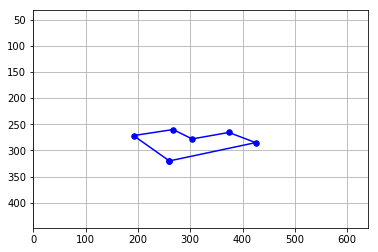

In [13]:
H = np.array([[250,-11, 260],
              [22,  33, 320],
              [0.2,  0.3, 1]])

img = htrans(H,ref)

shcont(img)
plt.axis('equal'); plt.ylim(480,0); plt.xlim(0,640); plt.grid()

La matriz de transformación es del grupo **proyectivo**, no tiene ninguna restricción en sus 9 elementos.

## Estimación de transformaciones

Un problema clave de la geometría visual es encontrar la transformación proyectiva que relaciona dos conjuntos de puntos. Esto implica resolver un [sistema de ecuaciones](sistecs.ipynb). (Como veremos [más adelante](DLT.ipynb), es posible escribir una función sencilla que resuelve este problema.) En la práctica es recomendable usar la función de OpenCV `findHomography`. (La palabra *homography* significa "transformación proyectiva" (transformación lineal de coordenadas homogéneas $\simeq$ matriz $3\times 3$.)

Comprobamos que  `findHomography` funciona bien con los datos del ejemplo artificial anterior. Sabemos que los puntos

In [14]:
img

array([[260.        , 320.        ],
       [191.53846154, 271.53846154],
       [267.14285714, 260.        ],
       [303.6       , 278.        ],
       [373.7037037 , 265.55555556],
       [425.        , 285.        ]])

son el resultado de aplicar

In [15]:
sharr(H)

[[250.  -11.  260. ]
 [ 22.   33.  320. ]
 [  0.2   0.3   1. ]]


a los puntos

In [16]:
ref

array([[0. , 0. ],
       [0. , 1. ],
       [0.5, 1. ],
       [0.5, 0.5],
       [1. , 0.5],
       [1. , 0. ]])

Efectivamente, recuperamos la transformación a partir de los puntos correspondientes:

In [17]:
He, mask = cv.findHomography(ref, img)

sharr(He)

[[250.  -11.  260. ]
 [ 22.   33.  320. ]
 [  0.2   0.3   1. ]]


También devuelve un array "mask" indicando las correspondencias que se consideran correctas, ya que `findHomography` puede, opcionalmente, aplicar técnicas de estimación robusta capaces de tolerar correspondencias erróneas.

Una transformación proyectiva queda completamente determinada cuando sabemos cómo actúa sobre 4 puntos.
Tiene 8 grados de libertad (la matriz $3\times3$ tiene 9 coeficientes pero el factor de escala global es arbitrario). Como cada punto del plano tiene 2 grados de libertad, los 8 grados de libertad de la transformación quedan fijados por 4 puntos.

Si queremos estimar una transformación proyectiva a partir del número mínimo de 4 puntos, podemos usar la función más simple `cv.getPerspectiveTransform`. Si hay más, tenemos información redundante pero que en la práctica es útil para mejorar la estimación a partir de datos con ruido. En este caso usamos `cv.findHomography`.

## Rectificación de planos

Si descubrimos en una imagen plana 4 ó más puntos cuyas posiciones reales son conocidas podemos obtener la homografía que se ha producido y "deshacerla".

El análogo a `htrans` para imágenes completas es `cv.warpPerspective`. Podemos probar algunas transformaciones:

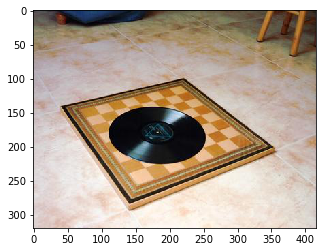

In [18]:
img = readrgb('disk1.jpg')

plt.imshow(img);

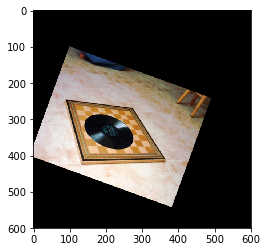

In [19]:
rec = cv.warpPerspective(
    img,                                # imagen de entrada
    desp((100,100)) @ rot3(20*degree),  # homografía (matriz 3x3)
    (600,600))                          # tamaño de la imagen resultante

plt.imshow(rec);    

Nos interesa la homografía que convierte los vértices del tablero de ajedrez en un cuadrado. Cuando la apliquemos rectificará toda la imagen: arrastrará a todos los demás puntos a su posición correcta.

Para no complicar ahora mucho el ejemplo encontramos manualmente por prueba y error las coordenadas aproximadas de las esquinas del tablero:

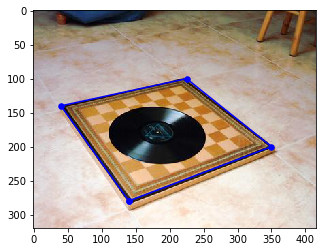

In [20]:
view = np.array([
        [140,280],
        [40,140],
        [225,100],
        [350,200]])

plt.imshow(img);
shcont(view);

Vamos a transformar las cuatro esquinas observadas en un cuadrado. Elegimos las siguientes coordenadas para que el tablero recitificado tenga 100 pixels de lado, por ejemplo, y quede bien situado en la imagen final (por prueba y error),

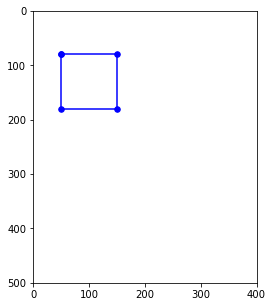

In [21]:
real = np.array([
    [  50.,   80.],
    [ 150.,   80.],
    [ 150.,  180.],
    [  50.,  180.]])

fig(4,5); shcont(real); plt.axis([0,400,500,0]);

In [22]:
H,_ = cv.findHomography(view, real)

sharr(H)

[[ -0.353  -0.659 334.276]
 [  0.544  -0.112 115.368]
 [ -0.001   0.004   1.   ]]


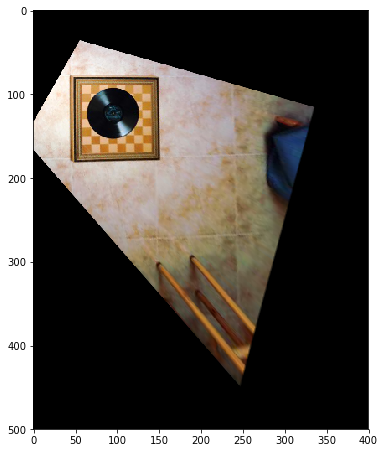

In [23]:
rec = cv.warpPerspective(img,H,(400,500))

fig(6,8)
plt.imshow(rec);    

Hemos ajustado manualmente el desplazamiento, escalado y tamaño de imagen destino para que quede bien.

La transformación que rectifica los 4 puntos de referencia corrige todo el plano del suelo. El disco se vuelve circular y las baldosas recuperan su forma cuadrada.

Los objetos que no están en ese plano quedan completamente deformados.

La imagen rectificada pierde precisión a medida que nos alejamos de los puntos de referencia.

El rectángulo visible de la imagen inicial se convierte en un cuadrilátero irregular en la imagen rectificada. La zona negra exterior queda indefinida. Se puede recortar la zona de interés, o elegir la homografía y el tamaño del destino para que el resultado quede completamente relleno. 

La función `cv.warpPerspective` tiene un segundo modo de funcionamiento en el que el resultado de la transformación se añade encima de una imagen de destino existente. En este caso se utiliza la opción de borde transparente para que la zona negra exterior no machaque el resto de la imagen destino. (Se muestra un ejemplo de uso en la última sección de este notebook "Warping con borde transparente".)

Hemos estimado directamente la transformación de rectificación (imagen $\rightarrow$ referencia). También se puede estimar la transformación de perspectiva sufrida (referencia $\rightarrow$ imagen) y aplicar su inversa.

In [24]:
H,_ = cv.findHomography(real, view)
H = la.inv(H)
sharr(H)

[[ -0.11   -0.205 103.866]
 [  0.169  -0.035  35.847]
 [ -0.      0.001   0.311]]


No es la misma matriz (tiene un factor de escala global distinto) pero es la misma transformación. Si ajustamos la escala poniendo un uno en el mismo elemento comprobamos que los demás elementos son iguales (salvo errores de redondeo).

In [25]:
sharr(H/H[2,2])

[[ -0.353  -0.659 334.276]
 [  0.544  -0.112 115.368]
 [ -0.001   0.004   1.   ]]


**Importante**: Los puntos de referencia no tienen que formar necesariamente un cuadrado. Simplemente necesitamos conocer las posiciones relativas de 4 o más puntos.

En definitiva, con una homografía se pueden mover 4 puntos cualesquiera a las posiciones que deseemos. El resto de la imagen es arrastrada de forma coherente con ellos. Por tanto, es fácil programar numerosos efectos.

Para facilitar al máximo la detección de las coordenadas de un objeto conocido podemos aprovechar el paquete `pyzbar`, que nos devuelve las esquinas de los códigos QR (ejemplo `code/zbardemo.py`). Por ejemplo, podemos reproducir un vídeo en el código QR:

![qrvirt1](../images/demos/qrvirt1.png)

![qurvirt2](../images/demos/qrvirt2.png)

Para conseguir este efecto hay que utilizar el segundo modo de funcionamiento de `cv.warpPersepctive` con borde transparente.

Otro efecto divertido es el intercambio de cuadriláteros en una escena. Podemos cambiar los cuadros de sitio sin descolgarlos de la pared:

![noflipped](../images/demos/noflipped.png)

![noflipped](../images/demos/flipped.png)

En una escena en la que se vean dos pantallas de ordenador podemos intercambiar lo que se muestra en cada una.

OJO: no es trivial hacer esto automáticamente, es difícil detectar los cuadriáteros de interés de forma robusta.

**Ejercicio SWAP**: Escribe una función `copy_quad(p,src,q,dst)` que mueve un cuadrilátero `p` (los cuatro puntos almacenados en un array $4\times2$) de una imagen `src` a un cuadrilátero `q` en la imagen `dst`. (Pista: necesitarás un máscara y es conveniente reducir la operación al "bounding box" de las regiones.) Utilízala para reproducir el experimento anterior marcando los puntos de referencia manualmente.

Volviendo a la rectificación de planos, si tenemos la homografía de rectificación y conocemos el tamaño real del objeto de referencia, podemos deducir las medidas reales de los objetos situados en el plano. Lo único que necesitamos es conocer el factor de escala que relaciona las dimensiones de la imagen rectificada y el objeto real.

Un experimento interesante consiste en construir un medidor de distancias que se apoya en la detección de un DNI o tarjeta bancaria. Es un objeto plano de referencia de tamaño estándar (85mm$\times$54mm) que siempre tenemos a mano. Por ejemplo, podemos usar el carnet de la UMU:

![rectif](../images/demos/rectif/dni.png)

Suponiendo que podemos estimar las esquinas, aplicamos el procedimiento anterior para rectificar el plano de la mesa. El rectángulo destino debe tener la proporción correcta. Si no la tiene, 
o nos equivocamos en la asociación de puntos (asociando el lado corto con el lado largo), la imagen rectificada estará mal:

![rectif](../images/demos/rectif/dni5.png)

Cuando la asociación de puntos es correcta la imagen rectificada recupera las proporciones correctas: por ejemplo, la pila de botón se vuelve circular. Observa también que los planos paralelos a la mesa también ser rectifican correctamente (la cara superior del cubo de Rubick) pero en ellos cambia la escala.


![rectif](../images/demos/rectif/dni3.png)


El factor de escala que he elegido es 1 pixel por milímetro. Marcando dos puntos en la imagen rectificada podemos deducir inmediatamente la distancia real entre ellos. Pero también se pueden marcar los puntos en la imagen original y transformarlos:

![rectif](../images/demos/rectif/dni4.png)

En realidad el cubo mide 5cm de lado. Las medidas que conseguimos con este método son aproximadas. El error aumenta al alejarnos de la referencia. Hay varias fuentes de incertidumbre, entre las que se incluye la precisión de los puntos marcados y los de referencia.

Si nos mantenemos muy cerca del plano de la mesa las medidas son aproximadameante correctas:

![rectif](../images/demos/rectif/dni1.png)

Pero fuera del plano los resultados no son válidos:

![rectif](../images/demos/rectif/dni2.png)

**Ejercicio RECTIF (a)**: Reproduce el experimento anterior y mide la longitud de la cuchara. Mide la distancia entre las monedas en `coins.png`.

**Ejercicio**: Detecta automáticamente el carnet y estima con precisión las esquinas del rectángulo.

En esta escena la detección del carnet es sencilla porque contrasta bastante bien con el color de la mesa. Se puede umbralizar automáticamente con el método de OTSU.

Pero el principal problema que se plantea aquí es que las esquinas están redondeadas. La estimación automática de los vértices del rectángulo pasa por analizar el contorno para encontrar tramos "muy rectos", a partir de los cuales se puede deducir la posición de los vértices con las operaciones geométricas que vimos en la clase anterior.

**Ejercicio DNI**: Sustituye la foto de un carnet en tiempo real.

**Ejercicio SUDO**: Rellena un sudoku en tiempo real.

Recuerda que los puntos de referencia no tienen por qué formar un rectángulo. Y pueden ser más de cuatro, para aumentar la precisión. De hecho, los marcadores rectangulares tienen un problema de ambigüedad. Un marcador asimétrico como el siguiente define perfectamente el sistema de coordenadas del plano (y como veremos en el capítulo siguiente, también del espacio 3D), y además tiene una redundancia que permite descartar polígonos de 6 lados que no tengan la forma del marcador. Veremos la forma de detectar automáticamente este marcador en la clase de prácticas.

![marcador](../images/ref.png)

Otra posibilidad es utilizar un marcador como el siguiente, compuesto de 4 círculos situados en posiciones conocidas. Los círculos se proyectan en la imagen como elipses que pueden detectarse sin mucha dificultad, como veremos en la sesión práctica.

<img src="../images/elipses/circles1.png" width="30%">

En otras ocasiones no hay ningún marcador artificial en la escena, pero con un poco de suerte se pueden encontrar puntos de referencia.

**Ejercicio RECTIF (b)**: Determina la distancia a la portería a la que se encuentra el jugador que está tirando a puerta. 

![eder](../images/gol-eder.png)



Debes elegir puntos de referencia visibles en la escena que tengan posiciones fijas en un campo de fútbol (algunas dimensiones del campo son variables).

Esto no se puede automatizar, hay que marcar los puntos de referencia a mano. Para que sirva en otras fotos almacena en un archivo de texto que se pasa como parámetro las coordenadas reales de los puntos elegidos. 

### Transformaciones afines

Las transformaciones afines (que incluyen desplazamientos, rotaciones y escalados diferentes en cada eje) tienen 6 grados de libertad. Quedan definidas por la transformación sufrida por 3 puntos. La matriz de transformación se obtiene con la función `cv.getAffineTransform`.

Nota 1: Esta función (igual que cv.getPerspectiveTransform) requiere datos de tipo np.float32.

Nota 2: La función devuelve una matriz $2x3$. Se sobreentiende que la última fila es $(0,0,1)$. Esta matriz se puede aplicar directamente con `cv.warpAffine`.

**Experimento**: Las caras detectadas con los face_landmarks del paquete DLIB proporcionan 3 puntos de referencia (ojos y parte superior de la boca) razonablemente estables, que no dependen de la expresión de la cara. Si los llevamos a unas coordenadas fijas conseguimos una normalización afín de las caras:

![faces-normal](../images/demos/faces-normal.png)

(La máquina de deep learning *FaceNet* para reconocimiento de caras utiliza esta normalización como preproceso para entrenar el descriptor.)

**Ejercicio  NFACE**: Reproduce la imagen anterior. Coloca todas las caras detectadas en la imagen de entrada ordenadas en una o varias filas, con los ojos y la boca en posiciones fijas.

**Ejercicio**: Escribe una función `move_tri(p,src,q,dst)` que transfiere el triángulo definido por los puntos `p` (tres puntos almacenados en un array $3\times2$) de la imagen `src` al triángulo `q` de la imagen destino.

## Mosaico de imágenes

Las vistas de un plano desde diferentes puntos de vista están relacionadas por una homografía, como acabamos de ver.

Se puede demostrar que las imágenes del mundo 3D tomadas desde la misma posición también se relacionan mediante homografías planas. Esto nos permite hacer un mosaico, "pegando" todas en un marco de referencia común.

Recuerda: para hacer mosaicos, si la escena es 3D la cámara puede rotar o hacer zoom, pero no puede desplazarse. Si la escena es plana, las imágenes se pueden tomar desde cualquier posición.

Vamos a intentar encontrar automáticamente las homografías utilizando puntos de interés y sus descriptores como vimos en una clase anterior.

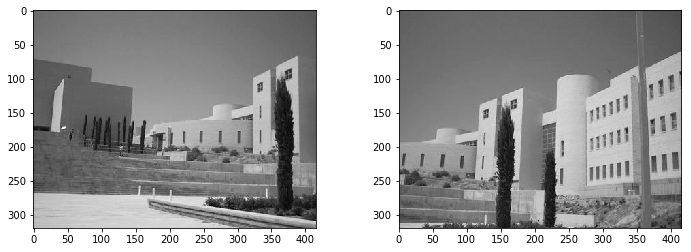

In [26]:
rgb1 = readrgb('pano/pano001.jpg')
rgb2 = readrgb('pano/pano002.jpg')

x1 = rgb2gray(rgb1)
x2 = rgb2gray(rgb2)

fig(12,4)
plt.subplot(1,2,1); imshowg(x2);
plt.subplot(1,2,2); imshowg(x1);

In [27]:
sift = cv.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(x1, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

# kps: 629, descriptors: (629, 128)


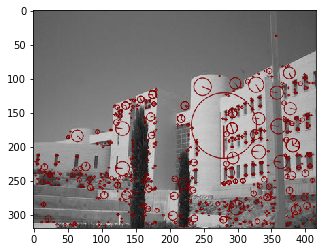

In [28]:
plt.imshow( cv.drawKeypoints(image=x1,
                             outImage=None,
                             keypoints=kps,
                             flags=4, color = (128,0,0)) );

In [29]:
(kps2, descs2) = sift.detectAndCompute(x2, None)
descs2.shape

(585, 128)

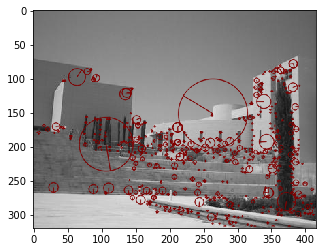

In [30]:
plt.imshow( cv.drawKeypoints(image=x2,
                             outImage=None,
                             keypoints=kps2,
                             flags=4, color = (128,0,0)) );

In [31]:
bf = cv.BFMatcher()

matches = bf.knnMatch(descs2,descs,k=2)

len(matches)

585

154


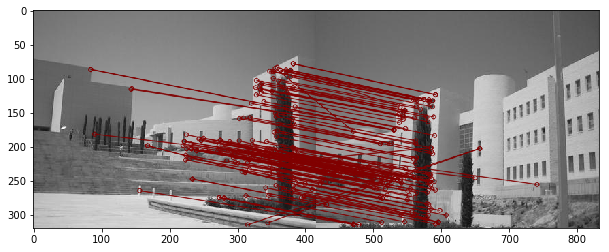

In [32]:
# para quedarnos solo los que tienen muy poca ambigüedad.

# Apply ratio test
good = []
for mt in matches:
    if len(mt) == 2:
        best, second = mt
        if best.distance < 0.75*second.distance:
            good.append(best) 

print(len(good))
        
# drawMatches usa la estructura matches1to2
img3 = cv.drawMatches(x2,kps2,
                      x1,kps,
                      good,
                      flags=2,outImg=None,
                      matchColor=(128,0,0))
fig(12,4)
plt.imshow(img3);

Se han encontrado muchas correspondencias pero algunas son incorrectas. Necesitaremos una técnica de estimación robusta como [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus). ("*random sample consensus*", que prueba muchas hipótesis y se queda con la que tiene más correspondencias compatibles).

In [33]:
# a partir de los matchings seleccionados construimos los arrays de puntos que necesita findHomography
src_pts = np.array([ kps [m.trainIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)
dst_pts = np.array([ kps2[m.queryIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)

In [34]:
H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 3) # cv.LMEDS

In [35]:
sharr(H)

[[  0.79    0.087 200.21 ]
 [ -0.145   0.966 -22.404]
 [ -0.001   0.      1.   ]]


Por curiosidad podemos ver las correspondencias que el método RANSAC considera correctas (aunque no hacen falta para nada más).

In [36]:
# mask viene como una array 2D de 0 ó 1, lo convertimos a un array 1D de bool
matchesMask = mask.ravel()>0

ok = [ good[k] for k in range(len(good)) if matchesMask[k] ]

# good es una lista, si fuera un array prodríamos hacer directamente
# ok = good[matchesMask]

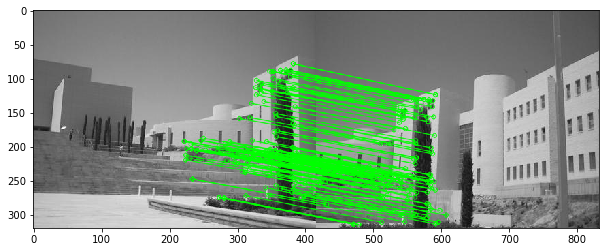

In [37]:
img4 = cv.drawMatches(x2,kps2,x1,kps,ok,flags=2,outImg=None,matchColor=(0,255,0))

fig(12,4)
plt.imshow(img4);

El paso siguiente es llevar todas las imágenes a un marco común con espacio suficiente. Para ello podemos usar la siguiente función auxiliar:

In [38]:
def t(h,x):
    return cv.warpPerspective(x, desp((100,150)) @ h,(1000,600))

La imagen "base" queda así:

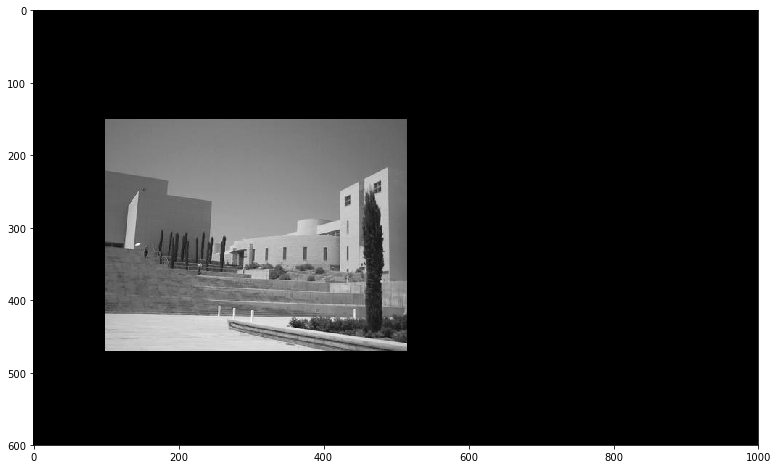

In [39]:
fig(15,8)

imshowg( t(np.eye(3),x2) )

Y la otra queda transformada para coincidir en la zona común:

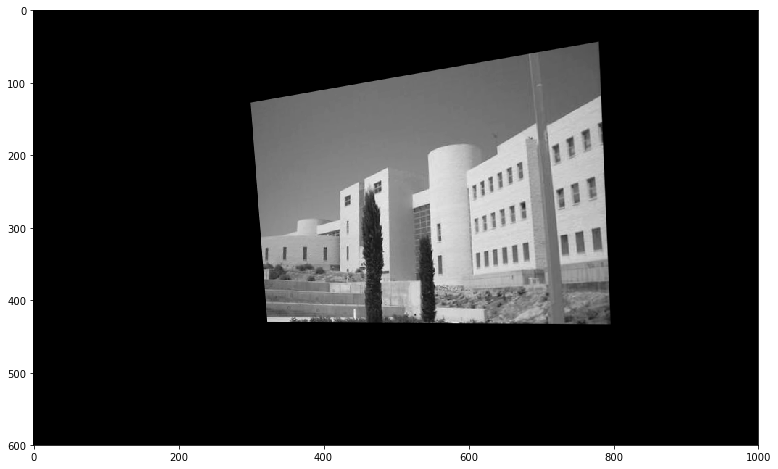

In [40]:
fig(15,8)

imshowg( t(H,x1) )

Una forma rápida de combinar las dos es tomar el máximo:

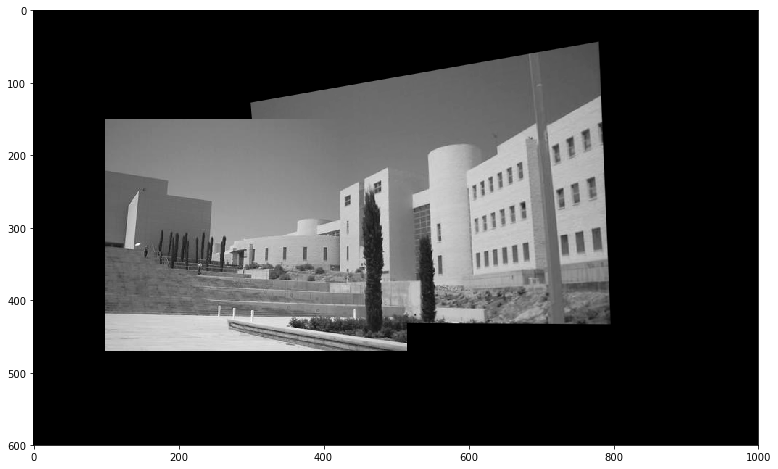

In [41]:
fig(15,8)

imshowg( np.maximum( t(np.eye(3),x2), t(H,x1) ) );

También funciona en color.

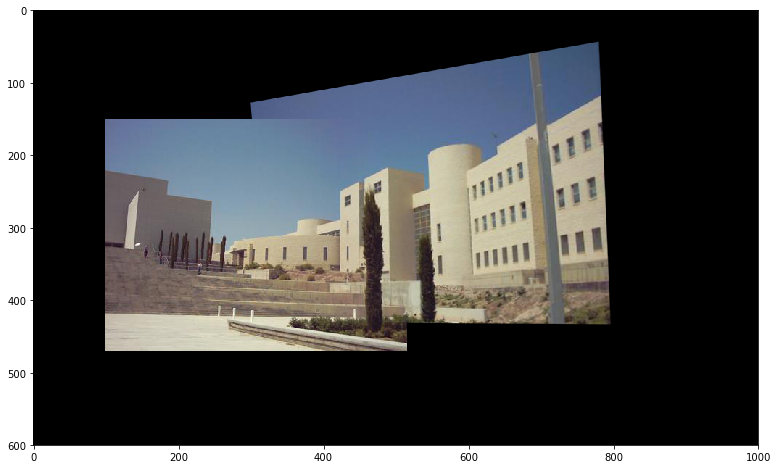

In [42]:
fig(15,8)

plt.imshow( np.maximum( t(np.eye(3),rgb2) , t(H,rgb1) ) );

En la colección de imágenes tenemos 7 vistas (pano/pano001.jpg ... pano/pano007.jpg) que pueden usarse para hacer un mosaico más grande. Pero ¡ojo! cuando el panorama abarca un ángulo grande la distorsión se hace enorme y es necesario recurrir a una proyección cilíndrica o esférica.

OpenCV tiene una [clase](https://docs.opencv.org/3.4.1/d2/d8d/classcv_1_1Stitcher.html) para crear automáticamente panoramas. Su uso, muy simple, se ilustrada en el ejemplo de código [`stitcher.py`](../code/stitcher.py). Aquí vemos el resultado que se consigue sobre nuestras imágenes y cómo la proyección esférica empleada permite abarcar un ángulo muy grande a costa de curvar las líneas rectas.

![stitched](../images/demos/stitched.jpg)

Aquí podemos encontrar un documento interesante sobre la construcción de [panoramas](https://graphics.stanford.edu/courses/cs448a-10/kari-panoramas-02mar10-opt.pdf).

### *Warping* con borde transparente

Una alternativa al método anterior de unión de imágenes consiste realizar la transformación directamente sobre la una imagen existente en lugar de crear una nueva. En este caso hay que poner borde transparente.

In [43]:
# utilidad para devolver el número de correspondencias y la homografía entre dos imágenes

sift = cv.xfeatures2d.SIFT_create()
bf = cv.BFMatcher()

def match(query, model):
    x1 = query
    x2 = model
    (k1, d1) = sift.detectAndCompute(x1, None)
    (k2, d2) = sift.detectAndCompute(x2, None)
    
    matches = bf.knnMatch(d1,d2,k=2)
    # ratio test
    good = []
    for m in matches:
        if len(m) == 2:
            best, second = m
            if best.distance < 0.75*second.distance:
                good.append(best)
    
    #if len(good) < 6: return 6, None
    
    src_pts = np.array([ k2[m.trainIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)
    dst_pts = np.array([ k1[m.queryIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)
    
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 3)
    
    return sum(mask.flatten()>0), H

In [44]:
import glob

def readraw(file):
    return cv.cvtColor( cv.imread(file), cv.COLOR_BGR2RGB) 

pano = [readrgb(x) for x in sorted(glob.glob('../images/pano/pano*.jpg'))]
len(pano)

8

In [45]:
print(match(pano[1],pano[3]))

(5, array([[-5.91700429e-01, -5.27825127e-02,  4.43080320e+01],
       [-2.15374127e+00, -3.84341973e-01,  2.44114968e+02],
       [-9.87688561e-03, -1.31603114e-03,  1.00000000e+00]]))


Probamos todas las parejas y las ordenamos por número de correspondencias.

In [46]:
sorted([(match(p,q)[0],i,j) for i,p in enumerate(pano) for j,q in enumerate(pano) if i< j],reverse=True)

[(130, 6, 7),
 (124, 1, 2),
 (77, 5, 6),
 (76, 0, 1),
 (54, 2, 3),
 (38, 4, 5),
 (38, 3, 4),
 (30, 5, 7),
 (7, 4, 6),
 (6, 2, 5),
 (5, 2, 7),
 (5, 2, 6),
 (5, 2, 4),
 (5, 1, 7),
 (5, 1, 6),
 (5, 1, 5),
 (5, 1, 4),
 (5, 1, 3),
 (5, 0, 7),
 (5, 0, 4),
 (5, 0, 3),
 (5, 0, 2),
 (4, 4, 7),
 (4, 3, 6),
 (4, 3, 5),
 (4, 0, 6),
 (4, 0, 5),
 (0, 3, 7)]

Elegimos como base la que tiene más corresponencias.

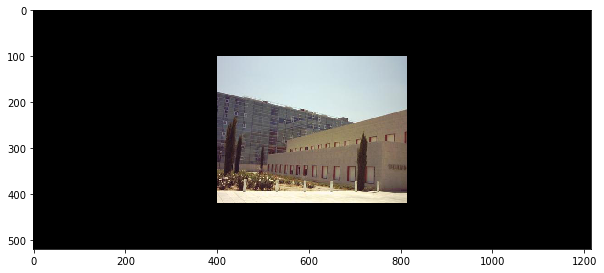

In [47]:
h,w,_ = pano[6].shape
mw,mh = 400,100
T = desp((mw,float(mh)))
sz = (w+2*mw,h+2*mh)
base = cv.warpPerspective(pano[6], T , sz)

fig(10,6)
plt.imshow(base);

Vamos añadiendo las que tengan más correspondencias con alguna anterior.

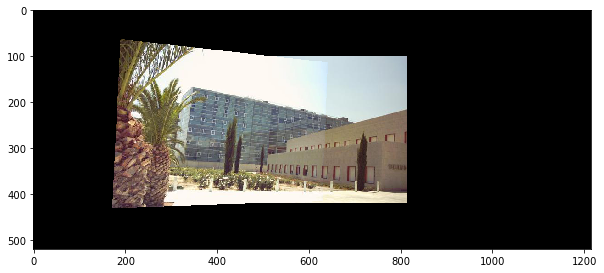

In [48]:
_,H67 = match(pano[6],pano[7])
cv.warpPerspective(pano[7],T@H67,sz, base, 0, cv.BORDER_TRANSPARENT)
fig(10,6)
plt.imshow(base);

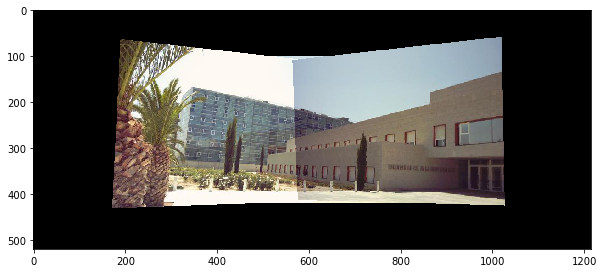

In [49]:
_,H65 = match(pano[6],pano[5])
cv.warpPerspective(pano[5],T@H65,sz, base, 0, cv.BORDER_TRANSPARENT)
fig(10,6)
plt.imshow(base);

Importante: la siguiente no tiene correspondencias con la base, pero podemos obtener la homografía mediante composición a través de una imagen intermedia:

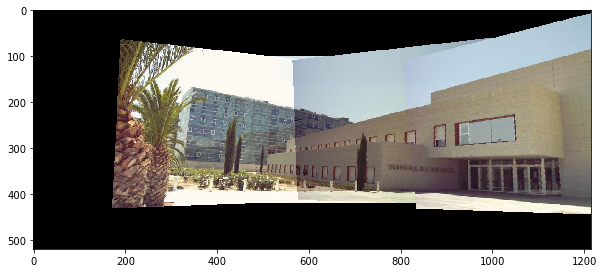

In [50]:
_,H54 = match(pano[5],pano[4])
cv.warpPerspective(pano[4],T@H65@H54,sz, base, 0, cv.BORDER_TRANSPARENT)
fig(10,6)
plt.imshow(base);

La base no tiene por qué ser la imagen central.

**Ejercicio PANO**. Crea automáticamente un mosaico a partir de las imágenes en una carpeta. Las imágenes no tienen por qué estar ordenadas ni formar una cadena lineal y no sabemos el espacio que ocupa el resultado. El usuario debe intervenir lo menos posible.